# Exercise 04: Distance Based Utility Model

- Agent's utility depends on **direct and indirect** connections
    - Connections are **undirected** $\to$ counted twice
    - Number of direct connections (**links**):  Degree $d_{i}$ 
    - **Length** $l_{ij}$ of \textbf{shortest path} between $i$ and $j$ (\# of hops)
    - If $(i,j)$ are not connected by a path: $l_{ij}\to \infty$
    - **Benefit** $b(l)$ **decreases**  with distance $l$
    - **Cost** per link is constant, $c$, agents maintain their direct links
- *Utility* of agent $i$: $$ u_{i} = \sum_{j \neq i} b(l_{ij}) - c\,d_i $$
    1. Choice of $b(l)$: $\delta^{l}$ with $0<\delta<1$ $\to \delta$, $\delta^{2}$, ... (``connections model'')
    2. Choice of $b(l)$: $b(1)=b_{1}>b(2)=b_{2}$, $b(l>2)=0$
- item Is it beneficial for agents to create links?
    - Reduce costs $\to$ less $direct$ links 
    - Increase benefits $\to$ more **direct/indirect** links, dependent on $b_{1}$, $b_{2}$

The original paper may serve as a useful resource:
https://doi.org/10.1006/jeth.1996.0108


In [1]:
import mesa
import numpy as np
import networkx as nx
import random

from mesa.datacollection import DataCollector
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
from visualization_functions import plot_network

## Section 1: Implement customs schedulers

Mesa's RandomActivation activates all agents in a random order at each step.
If we want to see how the different activation orders affect the model, we need to implement a custom scheduler that will activate agents in a random order, but only one per step.

`RandomSingleActivation` provides the code for a custom scheduler that activates one agent at random per step.

In [2]:
class RandomSingleActivation:
    """A scheduler that activates one random agent per step."""
    def __init__(self, model):
        self.model = model
        self.agents = []  # list of agents
        self.steps = 0

    def add(self, agent):
        self.agents.append(agent)

    def remove(self, agent):
        self.agents.remove(agent)

    def step(self):
        if self.agents:
            agent = random.choice(self.agents)
            agent.step()
        self.steps += 1


## Section 2: Implement the Distance Based Utility Model
Implement the following benefit funtion:
- `benefit`: $b(1)=b_{1}>b(2)=b_{2}$, $b(l>2)=0$

In [3]:
# -------------------------------
# Agent
# -------------------------------
class Agent(mesa.Agent):
    """
    Agent class for the network formation model.
    """
    def __init__(self, model, unique_id):
        super().__init__(model)
        self.model = model
        self.unique_id = unique_id

    @property
    def cost(self):
        """Cost of sustaining a link."""
        return self.model.cost

    def degree(self):
        """get number of neighbors from the network"""
        return self.model.net.degree(self.unique_id)

    def neighbors(self):
        """return the sequence of neighbors of the focal agent"""
        for uid in self.model.net.neighbors(self.unique_id):
            yield self.model.get_agent(uid)

    def non_neighbors(self):
        """return the sequence of non-neighbors of the focal agent"""
        neighbor_ids = {a.unique_id for a in self.neighbors()}
        all_ids = set(self.model.uids()) - {self.unique_id}
        for uid in all_ids - neighbor_ids:
            yield self.model.get_agent(uid)

    def component_uids(self, network=None):
        """returns the uids of the component in which this agent resides"""
        if network is None:
            network = self.model.net
        return next(c for c in nx.connected_components(network) if self.unique_id in c)

    def subgraph(self, network=None, copy=False):
        """The graph induced by selecting only the component to which the agent belongs."""
        if network is None:
            network = self.model.net
        comp = self.component_uids(network)
        sub_g = network.subgraph(comp)
        return sub_g.copy() if copy else sub_g

    # === Basic Actions ===
    # implement the basic actions of the agent
    def create_link_to(self, other):
        """Create a connection (edge) between this agent and another."""
        self.model.create_link(self, other)

    def delete_link_to(self, other):
        """Delete the connection (edge) between this agent and another."""
        self.model.delete_link(self, other)

    # --- Decision Variables ---
    def utility(self, subgraph):
        """Compute the agent's utility based on its position in a given subgraph."""
        shortest_paths = nx.single_source_shortest_path_length(subgraph, self.unique_id)
        deg = subgraph.degree(self.unique_id)
        util = sum(self.benefit(shortest_paths)) - self.cost * deg
        return util

    def benefit(self, shortest_paths):
        """Compute benefits based on shortest path lengths."""
        benefits = []
        for uid, distance in shortest_paths.items():
            if distance == 0:
                continue
            elif distance == 1:
                benefits.append(self.model.b1)
            elif distance == 2:
                benefits.append(self.model.b2)
        return benefits

     # --- Hypothetical Changes ---
    def subgraph_if(self, add_link_to=None, remove_link_to=None):
        """
        Construct a hypothetical subgraph after temporarily adding or removing links.
        At least one of add_link_to or remove_link_to must be provided.
        """
        if add_link_to is None and remove_link_to is None:
            raise ValueError("Must specify at least one change.")

        # Ensure we work with iterables.
        if add_link_to and not hasattr(add_link_to, '__iter__'):
            add_link_to = [add_link_to]
        if remove_link_to and not hasattr(remove_link_to, '__iter__'):
            remove_link_to = [remove_link_to]

        added = []
        if add_link_to:
            for other in add_link_to:
                if not self.model.link_exists(self, other):
                    self.create_link_to(other)
                    added.append(other)
        removed = []
        if remove_link_to:
            for other in remove_link_to:
                if self.model.link_exists(self, other):
                    self.delete_link_to(other)
                    removed.append(other)

        sub_g = self.subgraph(self.model.net, copy=True)

        for other in added:
            self.delete_link_to(other)
        for other in removed:
            self.create_link_to(other)

        return sub_g

    def gain_from_link(self, other, create=True):
        """Compute the gain from creating or deleting a link with another agent."""
        exists = self.model.link_exists(self, other)
        if create and exists:
            return 0.0
        if not create and not exists:
            return 0.0

        potential_sub = self.subgraph_if(add_link_to=other) if create else self.subgraph_if(remove_link_to=other)
        current_util = self.utility(self.subgraph())
        potential_util = self.utility(potential_sub)
        return potential_util - current_util

    def rank_agents(self, create=True):
            """
            Rank a (possibly sampled) set of agents based on the gain from linking.
            Returns a list of tuples (agent_unique_id, gain), sorted by gain descending.
            """
            valid_agents = list(self.non_neighbors() if create else self.neighbors())

            random.shuffle(valid_agents)
            sample = valid_agents

            gains = {}
            for other in sample:
                gain = self.gain_from_link(other, create)
                if gain > 0:
                    gains[other.unique_id] = gain
            # Sorted returns tuples (uid, gain)
            return sorted(gains.items(), key=lambda x: x[1], reverse=True) # sort by gain descending

    def best_simple_action(self, create=True, mutual=True):
        """
        Return the best single action gain and target agent.
        """
        ranked = self.rank_agents(create)
        if not ranked:
            return (0.0, None)
        # Correctly unpack: tuple is (uid, gain)
        if not mutual:
            uid, gain = ranked[0]
            return (gain, self.model.get_agent(uid))
        for uid, gain in ranked:
            other = self.model.get_agent(uid)
            if other.gain_from_link(self, create) >= 0:
                return (gain, other)
        return (0.0, None)
    
    def best_action(self, mutual_create=True, mutual_delete=True):
        """Returns the type of action to perform and with which agent that would
        maximize the utility if the action were to be carried out.

        Args:
            mutual_create (bool): require that both agents do not suffer utility losses (True) or in
                case of False only consider the utility of the proposing agent.
            mutual_delete (bool): delete only if both gain or if False only if the focal gains, but
                not necessarily the other

        Returns:
            bool, Agent: True -> create | False -> delete, Agent to perform the action on.

        Examples:
            >>> w = World(n=2)
            >>> agent0 = w[0]
            >>> agent0.best_action()
            (True, Agent(<World>, uid=1))
        """
        create_gain, create_target = self.best_simple_action(True, mutual_create)
        delete_gain, delete_target = self.best_simple_action(False, mutual_delete)
        if create_target and delete_target:
            return (True, create_target) if create_gain >= delete_gain else (False, delete_target)
        elif create_target:
            return (True, create_target)
        elif delete_target:
            return (False, delete_target)
        else:
            return (None, None)
        

    # --- Actions ---
    def best_action_update(self, mutual_creation=True, mutual_deletion=False):
        """Execute the best action (link creation/deletion) if beneficial."""
        create, target = self.best_action(mutual_creation, mutual_deletion)
        if target is not None:
            if create:
                self.create_link_to(target)
            else:
                self.delete_link_to(target)

    def step(self):
        mutual_create = self.model.mutual_create
        mutual_delete = self.model.mutual_delete
        self.best_action_update(mutual_create, mutual_delete)

In [4]:
# -------------------------------
# Model
# -------------------------------
class World(mesa.Model):
    """The World class represents the environment in which the Agents interact.

    The class keeps track of the Network on which the agents interact, the alterations to it
    over time as well as the model time
    """

    def __init__(self, num_agents, cost, mutual_create, mutual_delete,
                 delta, b1, b2, polling_interval=1, check_stability=1,
                 max_steps=None, plot_network=False):
        super().__init__()
        self.schedule = RandomSingleActivation(self)
        self.net = nx.Graph()
        self.cost = cost
        self._id_counter = 0
        self.polling_interval = polling_interval
        self.check_stability = check_stability
        self.mutual_create = mutual_create
        self.mutual_delete = mutual_delete
        self.max_steps = max_steps
        self.num_agents = num_agents
        self.delta = delta
        self.b1 = b1
        self.b2 = b2
        self.plot = plot_network

        self.agent_dict = {}
        self.add_agents(num_agents)

        self.datacollector = DataCollector({
            "welfare": lambda m: m.aggregate_welfare(),
            "density": lambda m: nx.density(m.net),
            "clustering": lambda m: nx.average_clustering(m.net),
            "num_components": lambda m: len(list(nx.connected_components(m.net))),
        })

        self.running = True

    # === Basic Actions ===

    def _generate_uid(self):
        uid = self._id_counter
        self._id_counter += 1
        return uid

    def add_agents(self, num_agents):
        for _ in range(num_agents):
            self.add_agent()

    def add_agent(self):
        uid = self._generate_uid()
        if uid in self.net:
            raise KeyError(f"uid {uid} already exists.")
        agent = Agent(self, uid)
        self.schedule.add(agent)
        self.net.add_node(uid)
        self.agent_dict[uid] = agent

    def get_agent(self, uid):
        return self.agent_dict[uid]

    def remove_agent(self, agent_uid):
        agent = self.get_agent(agent_uid)
        self.schedule.remove(agent)
        self.net.remove_node(agent_uid)
        del self.agent_dict[agent_uid]

    def create_link(self, agent1, agent2):
        self.net.add_edge(agent1.unique_id, agent2.unique_id)

    def delete_link(self, agent1, agent2):
        self.net.remove_edge(agent1.unique_id, agent2.unique_id)

    def uids(self):
        return self.agent_dict.keys()

    def agents(self):
        """A list of all agents currently active in the simulation

        Yields:
            Agent
        """
        return self.agent_dict.values()

    # === Network properties ===
    def aggregate_welfare(self):
        """Compute aggregated welfare (i.e. the sum of all utilities) of the agents in the network
        """
        return sum(a.utility(a.subgraph()) for a in self.agents())

    def link_exists(self, agent1, agent2):
        """Return True if a link exists False otherwise"""
        return self.net.has_edge(agent1.unique_id, agent2.unique_id)

    # === Stability Checks (to stop simulation) ===
    def is_pairwise_stable(self, agents=None, mutual_create=True, mutual_delete=True):
        """Return true if no agent would be willing to make a change (either create or delete)

        Args:
            agents (list of Agents): if the stability should only be checked for this subset pass a
                list of agents otherwise the stability is computed considering all agents
            mutual_create (bool): require that neither agent is worse off when creating the link
            mutual_delete (bool): require that neither agent is worse off when deleting the link

        Returns:
            Returns True if no agent wants to make a move, False otherwise
        """
        # short circuit logic to reduce the number of comparisons necessary to find that the
        # system is not stable (i.e. at least one agent wants to make a move).
        # If it is in fact stable all agents need to be tested
        if not self.is_deletion_stable(agents, mutual=mutual_delete):  # the first test is False -> all is False
            return False
        return self.is_creation_stable(agents, mutual=mutual_create)   # The first test has yielded True if the next test is False -> all is False

    def is_deletion_stable(self, agents=None, mutual=True):
        """Returns True if no Agent would be willing to delete a link"""
        return self._is_simple_action_stable(agents, create=False, mutual=mutual)

    def is_creation_stable(self, agents=None, mutual=True):
        """Returns True if no Agent would be willing to create one more edge"""
        return self._is_simple_action_stable(agents, create=True, mutual=mutual)

    def _is_simple_action_stable(self, agents, create, mutual):
        """Given either create=True or create=False (i.e. delete) the function returns True if no
        Agent would be willing to perform an action of the given type."""
        if agents is None:
            agents = list(self.agents())
        for agent in agents:
            _, other = agent.best_simple_action(create, mutual)
            if other is not None:
                return False
        return True

    def step(self):
        # at given interval report on the state of the system
        if self.schedule.steps % self.polling_interval == 0:
            self.datacollector.collect(self)
            if self.plot:
                plot_network(self)

        self.schedule.step()
        plt.show()

        if self.check_stability and (self.schedule.steps % self.check_stability == 0):
            if self.is_pairwise_stable(mutual_create=self.mutual_create,
                                       mutual_delete=self.mutual_delete):
                self.running = False

        if self.max_steps and self.schedule.steps >= self.max_steps:
            self.datacollector.collect(self)
            self.running = False


## Section 3: Run the model and explore the parameter space.
- Do your results match what discussed in the lecture?
- What happens if you start with a network with no links?
- What happens if you start with a network with all possible links?
- What happens if you change the cost of maintaining a link?
- What happens if you change the benefit function?

In [5]:
num_agents=5
b1 = 0.9
b2 = 0.4
print(b1 + ((num_agents-2)/2) * b2)

1.5


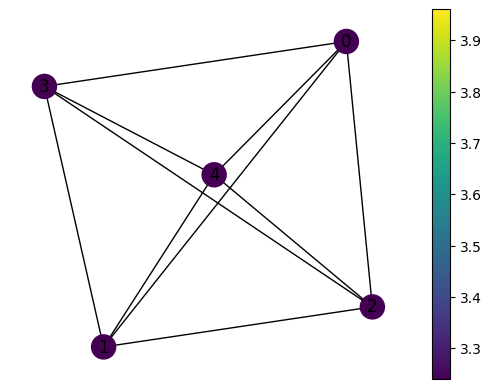

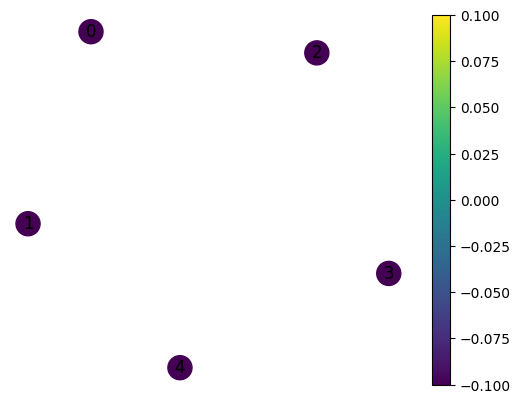

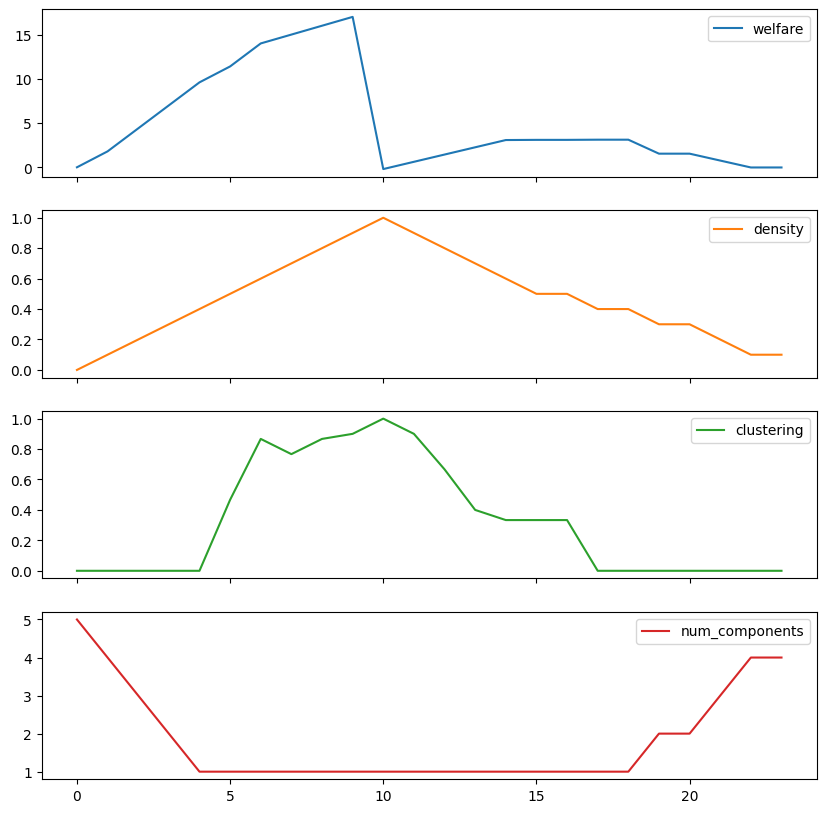

In [6]:
# initialize the network
world = World(num_agents=num_agents,
              cost=0,  
              mutual_create=True,
              mutual_delete=False,
              b1 = b1, b2 = b2,
              delta = .9,
              max_steps=2000,
              plot_network=False)
world.run_model()

plot_network(world)
# adapt costs 
world.cost = 0.91
world.running = True
world.run_model()

plot_network(world)
plt.show()

df = world.datacollector.get_model_vars_dataframe()
df.plot(subplots=True, figsize=(10, 10))
plt.show()

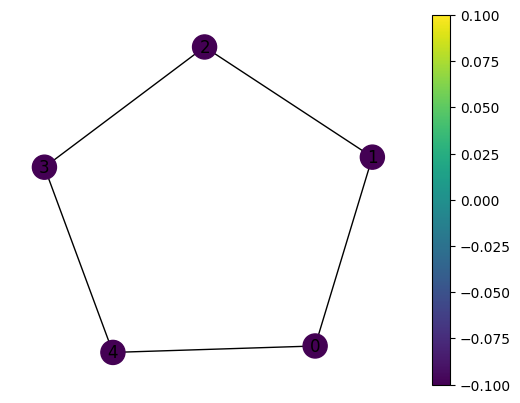

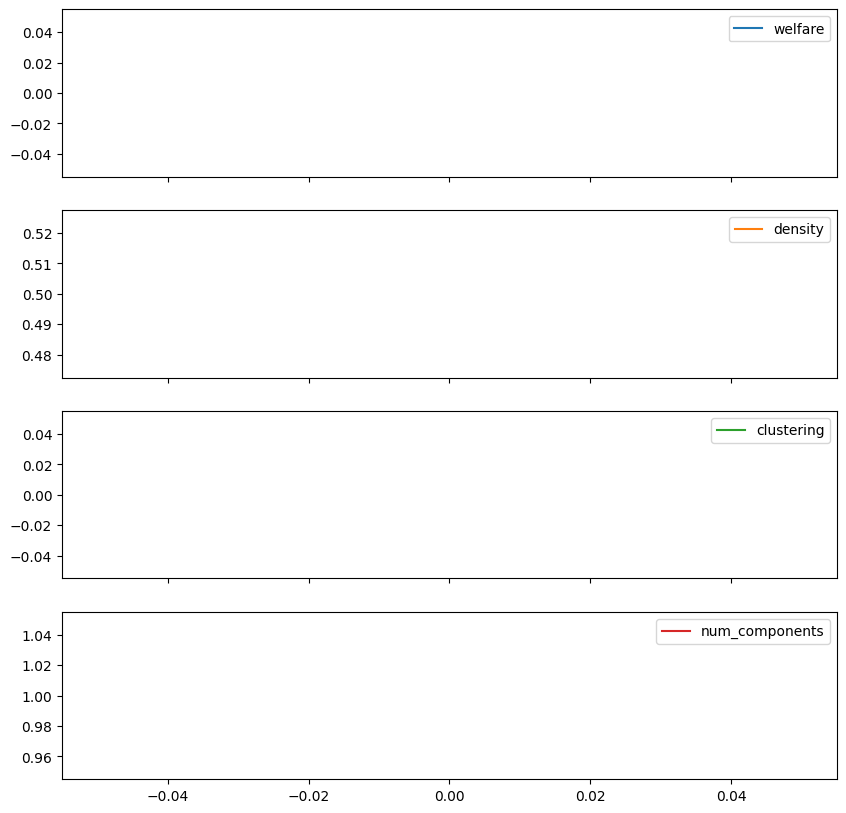

In [8]:
# initialize the network
world = World(num_agents=num_agents,
              cost=0,  
              mutual_create=True,
              mutual_delete=False,
              b1 = b1, b2 = b2,
              delta = .9,
              max_steps=2000,
              plot_network=False)

ring_edges = [(0,1), (1,2), (2,3), (3,4), (4,0)]
world.net.add_edges_from(ring_edges)
# world.run_model()


# # adapt costs 
world.cost = 1.3
world.running = True
world.run_model()

plot_network(world)
plt.show()

df = world.datacollector.get_model_vars_dataframe()
df.plot(subplots=True, figsize=(10, 10))
plt.show()